# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# from utils import data_read_dict, data_read_concat, data_merge
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize


name = 'LSTM_univariate2_classification'

In [2]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')
# %% read in data and adapt
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)
# df = df.loc[(df.iloc[:, :4] != 0).all(axis=1)]
df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
np.random.seed(42)
# df = df.iloc[np.random.choice(list(range(df.shape[0])), size=df.shape[0], replace=False), :]

In [4]:
# create a list of our conditions #!!! 
conditions = [
    (df[target] <= -0.00000001),
    (df[target] > -0.00000001) & (df[target] <= 0.00000001),
    (df[target] > 0.00000001)
]

# create a list of the values we want to assign for each condition #!!! 
values = ['sell', 'hold', 'buy']
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments #!!! 
df['strategy'] = np.select(conditions, values)
df.strategy = df.strategy.astype(np.int32)

# display updated DataFrame #!!! 
df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


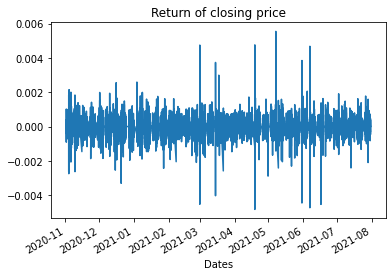

In [5]:
df['EURUSD BGNE Curncy Bid Close'].plot()
plt.title('Return of closing price')
plt.show()

In [6]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test = \
    ts_train_test_normalize(df, 128, 1, 1)

In [7]:
X_train = X_train[:, :, :-1].astype(dtype)
X_val = X_val[:, :, :-1].astype(dtype)
X_test = X_test[:, :, :-1].astype(dtype)
y_train = sc_target.inverse_transform(y_train).astype(dtype)
y_val = sc_target.inverse_transform(y_val).astype(dtype)
y_test = sc_target.inverse_transform(y_test).astype(dtype)

In [8]:
def LSTM_model():
    # The LSTM architecture
    act_fct = 'tanh'
    dr = 0.25
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=64, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(Flatten())
    my_LSTM_model.add(Dropout(dr))
    my_LSTM_model.add(Dense(units=128))
    my_LSTM_model.add(Dense(units=3, activation='softmax'))
    # my_LSTM_model.add(LSTM(units=1))
    return my_LSTM_model

In [9]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [10]:
def earlyStopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
if not os.path.exists('Benchmark/trained_models'):
    os.mkdir('Benchmark/trained_models')
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    'Benchmark/trained_models/%s____{epoch:04}.hdf5'%name,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)
def learning_rate_scheduler(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    elif epoch < 50:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001

In [11]:
from tensorflow.keras.optimizers import Adam
my_LSTM_model = LSTM_model()
my_LSTM_model.compile(
    optimizer=Adam(
        learning_rate=0.05
    ),
    loss=SparseCategoricalCrossentropy(from_logits=False),
#     loss='accuracy',
    metrics=['kullback_leibler_divergence', 'accuracy'],
)

history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
        # earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

Epoch 1/150
722/722 [==============================] - 15s 16ms/step - loss: 1.4629 - kullback_leibler_divergence: 4.5034 - accuracy: 0.4792 - val_loss: 0.8586 - val_kullback_leibler_divergence: 2.4493 - val_accuracy: 0.4506

Epoch 00001: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0001.hdf5
Epoch 2/150
722/722 [==============================] - 11s 16ms/step - loss: 0.8204 - kullback_leibler_divergence: 2.8747 - accuracy: 0.4901 - val_loss: 0.8248 - val_kullback_leibler_divergence: 2.5628 - val_accuracy: 0.4867

Epoch 00002: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0002.hdf5
Epoch 3/150
722/722 [==============================] - 11s 16ms/step - loss: 0.8202 - kullback_leibler_divergence: 2.8945 - accuracy: 0.4855 - val_loss: 0.8335 - val_kullback_leibler_divergence: 2.6598 - val_accuracy: 0.4711

Epoch 00003: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0003.hdf5
Epoch 4/150
722/722 [====

In [12]:
with open(f'Benchmark/trained_models/{name}____history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [13]:
if 'my_LSTM_model' not in globals():
    model_last = sorted([i for i in os.listdir('Benchmark/trained_models/') if name in i and 'hdf5' in i])[-1]
    my_LSTM_model = tf.keras.models.load_model(
        os.path.join('Benchmark/trained_models', model_last),
        custom_objects={'kl_divergence': kullback_leibler_divergence}
    )
if 'history' not in globals():
    with open(f'Benchmark/trained_models/{name}____history.pkl', 'rb') as f:
        history = pickle.load(f)
if hasattr(history, 'history'):
    history = history.history

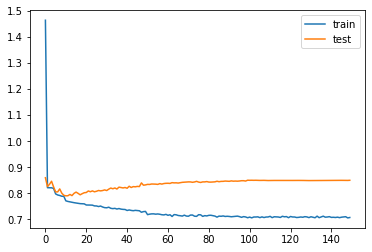

In [14]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

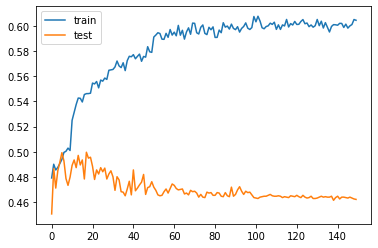

In [15]:
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

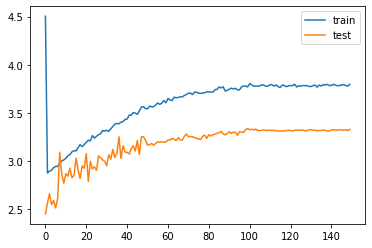

In [16]:
plt.plot(history['kullback_leibler_divergence'], label='train')
plt.plot(history['val_kullback_leibler_divergence'], label='test')
plt.legend()
plt.show()

In [17]:
my_LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 128)          66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 128)          131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128)          512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 64)           49408     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 64)           256       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.6520 - kullback_leibler_divergence: 2.9888 - accuracy: 0.6875
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6950 - kullback_leibler_divergence: 4.3019 - accuracy: 0.6562
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 0.6595 - kullback_leibler_divergence: 3.7302 - accuracy: 0.5938
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6874 - kullback_leibler_divergence: 4.0631 - accuracy: 0.5781
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6166 - kullback_leibler_divergence: 4.3227 - accuracy: 0.6250
Epoch 6/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6850 - kullback_leibler_divergence: 3.4175 - accuracy: 0.5781
Epoch 7/100
1/1 [==============================] - 0s 19ms/step - loss: 0.7349 - kullback_leibler_divergence: 3.1082 - accuracy: 0.6562
Epoch 8/100
1/1 [==============================] -

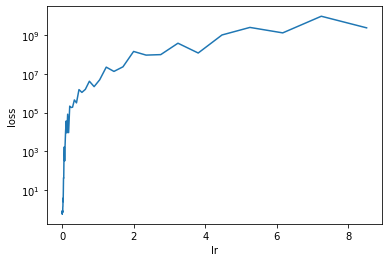

In [18]:
opt_learn_rate_plot(
    my_LSTM_model,
    X_train,
    y_train,
    10**-6,
    10**1,
    100,
    batch_size=64,
    steps_per_epoch=1,
    custom_objects={'kl_divergence': kullback_leibler_divergence}
)

In [19]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    balance = [start_capital]
    signal = None
    for i, d in enumerate(y_pred):
        if d == 0:
            signal = 0
            balance.append(balance[-1])
        elif d == 2:
            signal = 2
            balance.append(balance[-1] * ret[i])
        elif d == 1 and signal == 0:
            balance.append(balance[-1])
        elif d == 1 and signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

train
Accuracy: 0.6743208765983582
Accuracy: 0.4709501266479492
KL_Divergence: 56638.98046875
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66     10870
         1.0       0.89      0.72      0.80       926
         2.0       0.67      0.69      0.68     11285

    accuracy                           0.67     23081
   macro avg       0.74      0.69      0.71     23081
weighted avg       0.68      0.67      0.67     23081

[[7062   39 3769]
 [ 108  665  153]
 [3406   42 7837]]


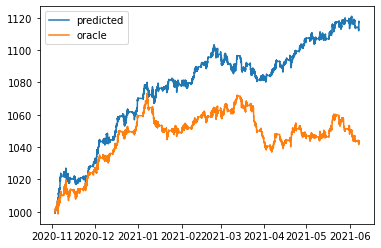

In [20]:
tmp_type = 'train'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(np.concatenate([eval(f"X_{tmp_type}"), eval(f"X_{tmp_type}")], axis =-1))[:, 0, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[X_test.shape[1]:], cumulated_return(y_pred, X_ret, dtype=dtype), label='predicted')
plt.plot(eval(f"index_{tmp_type}")[X_test.shape[1]:], cumulated_return(y, X_ret, dtype=dtype), label='oracle')
plt.legend()
plt.show()

val
Accuracy: 0.46212121844291687
Accuracy: 0.4942280054092407
KL_Divergence: 11476.0830078125
              precision    recall  f1-score   support

         0.0       0.47      0.46      0.46      1370
         1.0       0.31      0.11      0.16        82
         2.0       0.46      0.49      0.47      1320

    accuracy                           0.46      2772
   macro avg       0.41      0.35      0.37      2772
weighted avg       0.46      0.46      0.46      2772

[[630  12 728]
 [ 42   9  31]
 [670   8 642]]


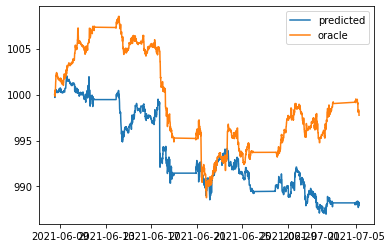

In [21]:
tmp_type = 'val'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(np.concatenate([eval(f"X_{tmp_type}"), eval(f"X_{tmp_type}")], axis =-1))[:, 0, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[X_test.shape[1]:], cumulated_return(y_pred, X_ret, dtype=dtype), label='predicted')
plt.plot(eval(f"index_{tmp_type}")[X_test.shape[1]:], cumulated_return(y, X_ret, dtype=dtype), label='oracle')
plt.legend()
plt.show()

test
Accuracy: 0.48593074083328247
Accuracy: 0.47330448031425476
KL_Divergence: 11121.484375
              precision    recall  f1-score   support

         0.0       0.48      0.48      0.48      1312
         1.0       0.09      0.05      0.07        75
         2.0       0.50      0.51      0.51      1385

    accuracy                           0.49      2772
   macro avg       0.36      0.35      0.35      2772
weighted avg       0.48      0.49      0.48      2772

[[636  18 658]
 [ 35   4  36]
 [655  23 707]]


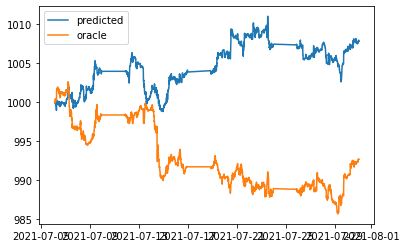

In [22]:
tmp_type = 'test'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(np.concatenate([eval(f"X_{tmp_type}"), eval(f"X_{tmp_type}")], axis =-1))[:, 0, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[X_test.shape[1]:], cumulated_return(y_pred, X_ret, dtype=dtype), label='predicted')
plt.plot(eval(f"index_{tmp_type}")[X_test.shape[1]:], cumulated_return(y, X_ret, dtype=dtype), label='oracle')
plt.legend()
plt.show()

cumulated_return(y_pred, X_ret, dtype=dtype)

In [33]:
x = cumulated_return(y_pred, X_ret, dtype=dtype)

(x[-1] / x[0]) / (np.std(x[1:] / x[:-1]) * np.sqrt(6 * 24 * 250))

28.579510562207048

In [23]:
# ax1 = fig.add_subplot(211)
# ax1.plot(index_train[X_train.shape[1]:], df_train[target], label='Training data')
# ax1.plot(index_val[X_train.shape[1]:], df_val[target], label='Validation data')
# ax1.plot(index_test[X_train.shape[1]:], df_test[target], label='Test data')
# ax1.set_xlabel('Dates')
# ax1.set_ylabel('Normalized Closing Returns')
# ax1.set_title("Close Price", fontsize=18)
# ax1.legend(loc="best", fontsize=12)